# Import Libraries

In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, IsolationForest, RandomForestRegressor

# Obtain Data

Read csv file with consumer reports ratings into pandas df

In [158]:
cr_df = pd.read_csv('Data/Ratings.csv')
cr_df = cr_df.iloc[:, range(1, len(cr_df.columns), 2)]
cr_df.columns = [x.replace('.1', '') for x in cr_df.columns]
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('mercedes-benz', 'mercedes benz'))
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('mercedes-amg', 'mercedes amg'))
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('land-rover', 'land rover'))
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('alfa-romeo', 'alfa romeo'))
cr_df['Brand'] = cr_df['Model'].apply(lambda x : x.split('-')[0])
def model_name(row):
    return row['Model'].replace(row['Brand']+'-', '')
cr_df['Model'] = cr_df.apply(model_name, axis=1)
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('-', ' '))
print('cr_df shape: ', cr_df.shape)
cr_df.head()

cr_df shape:  (295, 18)


,Model,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand
0,v60,1 / 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,volvo
1,500l,NaN,3 / 5,4 / 5,2 / 5,3 / 5,3 / 5,4 / 5,3 / 5,2 / 5,4 / 5,4 / 5,3 / 5,3 / 5,NaN,3 / 5,860 lb.,fiat
2,xf,NaN,5 / 5,5 / 5,5 / 5,4 / 5,5 / 5,4 / 5,5 / 5,2 / 5,3 / 5,5 / 5,3 / 5,4 / 5,NaN,3 / 5,960 lb.,jaguar
3,tt,NaN,5 / 5,5 / 5,3 / 5,3 / 5,5 / 5,1 / 5,5 / 5,2 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,2 / 5,770 lb.,audi
4,mirai,NaN,3 / 5,3 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,5 / 5,2 / 5,4 / 5,3 / 5,NaN,3 / 5,690 lb.,toyota


Read csv file with auto sales data into pandas df

In [159]:
def read_sales_excel(file, column, header):
    sales_df = pd.read_excel(file, header=header)
    sales_df.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
    sales_df.dropna(subset=[column], inplace=True)
    sales_df = sales_df[['Model', column]]
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('(D)', ''))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("(I)", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("*", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("‡", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("†", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("Total", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.strip())
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.lower())
    sales_df = sales_df.groupby('Model').agg({'Model':'first', column:'max'})
    sales_df.reset_index(inplace=True, drop=True)
    return sales_df
    
    
sales_df = read_sales_excel('Data/Auto_Sales/12-19-auto-sales.xls', '2019.1', 5)
sales_df.rename(columns={'2019.1': 'Sales'}, inplace=True)
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('-', ' '))
sales_df.head()

,Model,Sales
0,2 series,8015.0
1,200,48.0
2,3 series,47827.0
3,300,29213.0
4,370z,2384.0


Reformat sales_df model names to match cr_df model names for merger

In [160]:
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('mazda3', '3'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('mazda6', '6'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('f series', 'f 150'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('silverado', 'silverado 1500'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('ram pickup', '1500'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('discovery/lr4', 'discovery'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('spider', '124'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('e class/cls', 'e class'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('86 (incl. fr s)', '86'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('nautilus/mkx', 'nautilus'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a4/s4', 'a4'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a5/s5', 'a5'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a6/s6', 'a6'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a7/s7', 'a7'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a8/s8', 'a8'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('718', '718 boxster'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('countryman', 'cooper countryman'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('cooper s', 'cooper'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('90 series', 's90'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('60 series', 's60'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('370z', 'z'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('sierra', 'sierra 1500'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('slc/slk', 'slc'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('rl/rlx', 'rlx'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('glc/glk', 'glc'))
sales_df['Model'] = sales_df['Model'].replace({'gt': 'amg gt'})
sales_df = sales_df[sales_df['Model']!='golf']
sales_df.reset_index(drop=True, inplace=True)
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('golf/golf r/gti', 'golf'))
sales_df.head()

,Model,Sales
0,2 series,8015.0
1,200,48.0
2,3 series,47827.0
3,300,29213.0
4,z,2384.0


Merge sales_df and cr_df dataframes

In [161]:
df = pd.merge(sales_df, cr_df, on='Model')
df.head()

,Model,Sales,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand
0,2 series,8015.0,NaN,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw
1,3 series,47827.0,5 / 5,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw
2,300,29213.0,5 / 5,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler
3,z,2384.0,NaN,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan
4,4 series,18621.0,5 / 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,790 lb.,bmw


Read csv with model classes into df

In [162]:
model_class_df = pd.read_csv('Data/Vehicle_Classes.csv')
model_class_df = model_class_df.replace()
model_class_df.drop(columns='Brand', inplace=True)
model_class_df.head()

,Class,Model
0,Luxury Cars,lr2
1,Small Cars,astra
2,Sedans,passat
3,Suvs,discovery sport
4,Wagons,500l


Replace non-pickup truck classes with non-pickup truck class and remvoe duplicate rows

In [163]:
non_pickup_classes = list(model_class_df['Class'].value_counts().index)
non_pickup_classes.remove('Pickup Trucks')

def update_class(row):
    if row in non_pickup_classes:
        return 'Non Pickup Trucks'
    else:
        return 'Pickup Trucks'

model_class_df['Class'] = model_class_df['Class'].apply(update_class)
model_class_df.drop_duplicates(inplace=True)
for duplicate_model in list(model_class_df[model_class_df['Model'].duplicated()]['Model'].values):
     model_class_df = model_class_df[(model_class_df['Model'] != duplicate_model) | (model_class_df['Class'] != 'Non Pickup Trucks')]
model_class_df.head()

,Class,Model
0,Non Pickup Trucks,lr2
1,Non Pickup Trucks,astra
2,Non Pickup Trucks,passat
3,Non Pickup Trucks,discovery sport
4,Non Pickup Trucks,500l


Merge model_class_df with df

In [164]:
df = pd.merge(df, model_class_df, on='Model', how='left')
df.head()

,Model,Sales,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Class
0,2 series,8015.0,NaN,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw,Non Pickup Trucks
1,3 series,47827.0,5 / 5,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw,Non Pickup Trucks
2,300,29213.0,5 / 5,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler,Non Pickup Trucks
3,z,2384.0,NaN,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan,Non Pickup Trucks
4,4 series,18621.0,5 / 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,790 lb.,bmw,Non Pickup Trucks


Read csv with price data into pandas and scrub for merger with df

In [165]:
price_df = pd.read_csv('Data/Prices.csv')
price_df.drop(columns=['URL', 'Scrape URL', 'Brand', 'Model'], inplace=True)
price_df['Unit'] = price_df['Unit'].apply(lambda x: x.replace('_', ' '))
price_df.head()

,Unit,Price
0,v60,"$38,900"
1,500l,"$22,160"
2,xf,"$49,965"
3,tt,"$44,900"
4,mirai,"$58,500"


Merge price_df with df

In [166]:
df = pd.merge(df, price_df, left_on='Model', right_on='Unit', how='left')
df.drop(columns='Unit', inplace=True)
df.head()

,Model,Sales,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,...,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Class,Price
0,2 series,8015.0,NaN,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,...,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw,Non Pickup Trucks,"$35,300"
1,3 series,47827.0,5 / 5,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,...,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw,Non Pickup Trucks,"$40,250"
2,300,29213.0,5 / 5,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,...,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler,Non Pickup Trucks,"$29,470"
3,z,2384.0,NaN,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,...,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan,Non Pickup Trucks,"$30,090"
4,4 series,18621.0,5 / 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,790 lb.,bmw,Non Pickup Trucks,"$44,800"


Read csv with brand sales data into pandas df

In [167]:
brand_sales_df = pd.read_csv('Data/Brand_Sales.csv')
brand_sales_df.loc[len(brand_sales_df.index)] = ['Smart', 130]
brand_sales_df['Brand'] = brand_sales_df['Brand'].apply(lambda x: x.replace('Mercedes-Benz', 'Mercedes Benz'))
brand_sales_df['Brand'] = brand_sales_df['Brand'].apply(lambda x: x.lower())
brand_sales_df.head()

,Brand,Sales
0,acura,"157,385"
1,alfa romeo,"18,294"
2,audi,"224,111"
3,bmw,"324,825"
4,buick,"206,926"


Create df column with brand sales data for each vehicle

In [168]:
brand_sales_dict = {}
for num in range(0, len(brand_sales_df.index)):
    brand_sales_dict[brand_sales_df['Brand'].values[num]] = brand_sales_df['Sales'].values[num]
df['Brand Sales'] = df['Brand'].replace(brand_sales_dict)
df.head()

,Model,Sales,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,...,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Class,Price,Brand Sales
0,2 series,8015.0,NaN,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,...,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw,Non Pickup Trucks,"$35,300","324,825"
1,3 series,47827.0,5 / 5,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,...,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw,Non Pickup Trucks,"$40,250","324,825"
2,300,29213.0,5 / 5,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,...,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler,Non Pickup Trucks,"$29,470","126,972"
3,z,2384.0,NaN,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,...,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan,Non Pickup Trucks,"$30,090","1,227,973"
4,4 series,18621.0,5 / 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,790 lb.,bmw,Non Pickup Trucks,"$44,800","324,825"


Drop all pickup trucks fromt the data set and drop class feature

In [169]:
df = df[df['Class']!='Pickup Trucks']
df.drop(columns='Class', inplace=True)
df.head()

,Model,Sales,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,...,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Price,Brand Sales
0,2 series,8015.0,NaN,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,...,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw,"$35,300","324,825"
1,3 series,47827.0,5 / 5,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,...,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw,"$40,250","324,825"
2,300,29213.0,5 / 5,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,...,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler,"$29,470","126,972"
3,z,2384.0,NaN,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,...,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan,"$30,090","1,227,973"
4,4 series,18621.0,5 / 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,790 lb.,bmw,"$44,800","324,825"


# Scrub Data

Use df.info to determine what scrubbing needed 

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 261
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Model                    250 non-null    object 
 1   Sales                    250 non-null    float64
 2   Reliability              122 non-null    object 
 3   Acceleration             216 non-null    object 
 4   Braking                  216 non-null    object 
 5   Ride                     216 non-null    object 
 6   Noise                    216 non-null    object 
 7   Front Seat Comfort       216 non-null    object 
 8   Rear Seat Comfort        210 non-null    object 
 9   Interior Fit and Finish  216 non-null    object 
 10  Trunk/Cargo Area         216 non-null    object 
 11  Fuel Economy             216 non-null    object 
 12  Routine Handling         216 non-null    object 
 13  Headlights               216 non-null    object 
 14  Driving Position         2

Drop rows missing most or all ratings data

In [171]:
df = df[df.isna().sum(axis=1)<9]
df.head()

,Model,Sales,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,...,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Price,Brand Sales
0,2 series,8015.0,NaN,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,...,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw,"$35,300","324,825"
1,3 series,47827.0,5 / 5,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,...,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw,"$40,250","324,825"
2,300,29213.0,5 / 5,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,...,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler,"$29,470","126,972"
3,z,2384.0,NaN,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,...,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan,"$30,090","1,227,973"
6,4runner,131888.0,4 / 5,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,...,2 / 5,2 / 5,4 / 5,3 / 5,NaN,4 / 5,1155 lb.,toyota,"$35,310","2,085,206"


Drop Reliability feature due to large amount of missing data

In [172]:
df.drop(columns='Reliability', inplace=True)
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Price,Brand Sales
0,2 series,8015.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw,"$35,300","324,825"
1,3 series,47827.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw,"$40,250","324,825"
2,300,29213.0,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler,"$29,470","126,972"
3,z,2384.0,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan,"$30,090","1,227,973"
6,4runner,131888.0,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,2 / 5,4 / 5,3 / 5,NaN,4 / 5,1155 lb.,toyota,"$35,310","2,085,206"


Update Max. Load column to integer data type

In [173]:
df['Max. Load'] = df['Max. Load'].apply(lambda x: int(x.replace(' lb.', '')))
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Price,Brand Sales
0,2 series,8015.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805,bmw,"$35,300","324,825"
1,3 series,47827.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825,bmw,"$40,250","324,825"
2,300,29213.0,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865,chrysler,"$29,470","126,972"
3,z,2384.0,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450,nissan,"$30,090","1,227,973"
6,4runner,131888.0,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,2 / 5,4 / 5,3 / 5,NaN,4 / 5,1155,toyota,"$35,310","2,085,206"


Replace missing Rear Seat Comfort and Third Seat Comfort values with 0

In [174]:
rating_replace_dict = {np.nan: '0 / 5'}
df['Rear Seat Comfort'] = df['Rear Seat Comfort'].replace(rating_replace_dict)
df['Third Seat Comfort'] = df['Third Seat Comfort'].replace(rating_replace_dict)
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Price,Brand Sales
0,2 series,8015.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,0 / 5,4 / 5,805,bmw,"$35,300","324,825"
1,3 series,47827.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,0 / 5,3 / 5,825,bmw,"$40,250","324,825"
2,300,29213.0,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,0 / 5,4 / 5,865,chrysler,"$29,470","126,972"
3,z,2384.0,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,0 / 5,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,0 / 5,4 / 5,450,nissan,"$30,090","1,227,973"
6,4runner,131888.0,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,2 / 5,4 / 5,3 / 5,0 / 5,4 / 5,1155,toyota,"$35,310","2,085,206"


Replace Brand Sales feature with brand sales - model sales

In [175]:
df['Brand Sales'] = df['Brand Sales'].apply(lambda x: int(x.replace(',', '')))
df['Brand Sales'] = df['Brand Sales'] - df['Sales']
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Price,Brand Sales
0,2 series,8015.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,0 / 5,4 / 5,805,bmw,"$35,300",316810.0
1,3 series,47827.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,0 / 5,3 / 5,825,bmw,"$40,250",276998.0
2,300,29213.0,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,0 / 5,4 / 5,865,chrysler,"$29,470",97759.0
3,z,2384.0,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,0 / 5,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,0 / 5,4 / 5,450,nissan,"$30,090",1225589.0
6,4runner,131888.0,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,2 / 5,4 / 5,3 / 5,0 / 5,4 / 5,1155,toyota,"$35,310",1953318.0


Update Price column to integer data type

In [176]:
df['Price'] = df['Price'].apply(lambda x: int(x.replace(',', '')[1:]))
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Price,Brand Sales
0,2 series,8015.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,0 / 5,4 / 5,805,bmw,35300,316810.0
1,3 series,47827.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,0 / 5,3 / 5,825,bmw,40250,276998.0
2,300,29213.0,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,0 / 5,4 / 5,865,chrysler,29470,97759.0
3,z,2384.0,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,0 / 5,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,0 / 5,4 / 5,450,nissan,30090,1225589.0
6,4runner,131888.0,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,2 / 5,4 / 5,3 / 5,0 / 5,4 / 5,1155,toyota,35310,1953318.0


Update ratings columns to integer data type

In [177]:
ratings_columns = list(df.columns)
ratings_columns.remove('Model')
ratings_columns.remove('Sales')
ratings_columns.remove('Max. Load')
ratings_columns.remove('Brand')
ratings_columns.remove('Price')
ratings_columns.remove('Brand Sales')

for col in ratings_columns[0:14]:
    df[col] = df[col].apply(lambda x: int(x[0]))
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand,Price,Brand Sales
0,2 series,8015.0,5,5,3,4,5,2,4,2,4,5,1,4,0,4,805,bmw,35300,316810.0
1,3 series,47827.0,5,5,3,4,5,3,5,3,4,5,2,4,0,3,825,bmw,40250,276998.0
2,300,29213.0,4,4,4,5,5,5,5,3,3,4,1,4,0,4,865,chrysler,29470,97759.0
3,z,2384.0,5,5,2,2,4,0,5,1,3,5,4,2,0,4,450,nissan,30090,1225589.0
6,4runner,131888.0,4,4,2,4,4,4,3,4,2,2,4,3,0,4,1155,toyota,35310,1953318.0


Drop object columns not useful for modeling

In [178]:
df.drop(columns=['Model', 'Brand'], inplace=True)
df.head()

,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Price,Brand Sales
0,8015.0,5,5,3,4,5,2,4,2,4,5,1,4,0,4,805,35300,316810.0
1,47827.0,5,5,3,4,5,3,5,3,4,5,2,4,0,3,825,40250,276998.0
2,29213.0,4,4,4,5,5,5,5,3,3,4,1,4,0,4,865,29470,97759.0
3,2384.0,5,5,2,2,4,0,5,1,3,5,4,2,0,4,450,30090,1225589.0
6,131888.0,4,4,2,4,4,4,3,4,2,2,4,3,0,4,1155,35310,1953318.0


Update Sales feature to log(sales)

In [179]:
df['Sales'] = np.log(df['Sales'])

Confirm data scrubbed with df.info

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 261
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Sales                    216 non-null    float64
 1   Acceleration             216 non-null    int64  
 2   Braking                  216 non-null    int64  
 3   Ride                     216 non-null    int64  
 4   Noise                    216 non-null    int64  
 5   Front Seat Comfort       216 non-null    int64  
 6   Rear Seat Comfort        216 non-null    int64  
 7   Interior Fit and Finish  216 non-null    int64  
 8   Trunk/Cargo Area         216 non-null    int64  
 9   Fuel Economy             216 non-null    int64  
 10  Routine Handling         216 non-null    int64  
 11  Headlights               216 non-null    int64  
 12  Driving Position         216 non-null    int64  
 13  Third Seat Comfort       216 non-null    int64  
 14  Usability                2

# Explore Data

Identify outliers with isolation forest model

In [181]:
isf_x = df.drop(columns=['Sales'])
isf_y = df['Sales']
isf_xtrain, isf_xtest, isf_ytrain, isf_ytest = train_test_split(isf_x, isf_y,random_state=71, test_size=.5)

isf_ss = StandardScaler()
isf_ss.fit(isf_xtrain)
ss_isf_xtrain = pd.DataFrame(isf_ss.transform(isf_xtrain), columns=isf_xtrain.columns, index=isf_xtrain.index)

isf = IsolationForest(contamination=.05)
ss_isf_xtrain['Outlier'] = isf.fit_predict(ss_isf_xtrain)
ss_isf_xtrain[ss_isf_xtrain['Outlier']==-1].round(1)

,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Price,Brand Sales,Outlier
216,0.0,0.9,-1.7,-2.8,-1.6,-2.9,-1.5,-2.0,1.5,1.5,0.3,-2.9,-0.4,-0.5,-2.6,-0.7,-0.9,-1
18,1.4,0.9,-1.7,-1.8,-0.2,-2.0,1.1,-2.0,-0.3,1.5,-0.8,0.6,-0.4,-0.5,-1.3,3.2,-0.8,-1
260,0.0,-1.8,-0.5,1.2,-0.2,0.5,-0.2,2.3,-2.2,-2.4,0.3,0.6,3.7,1.2,2.2,0.9,-0.1,-1
205,0.0,-3.2,-1.7,0.2,-0.2,1.3,-0.2,2.3,-2.2,-1.1,0.3,-1.2,3.7,0.4,1.2,0.7,2.2,-1
215,-2.7,0.9,-1.7,-1.8,-1.6,-1.2,-2.8,-0.9,1.5,-1.1,0.3,-2.9,-0.4,0.4,-1.3,-1.4,2.0,-1
183,0.0,-1.8,0.6,0.2,-0.2,0.5,1.1,1.3,-2.2,-2.4,1.4,0.6,2.3,0.4,2.8,1.7,-0.7,-1


Calculate descriptive statistics for each feature

In [182]:
df.describe().iloc[:, 0:10].round(1)

,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy
count,216.0,216.0,216.0,216.0,216.0,216.0,216.0,216.0,216.0,216.0
mean,10.3,3.9,4.3,3.5,3.8,4.1,3.5,4.0,2.9,3.3
std,1.4,0.7,0.8,0.9,1.0,0.7,1.2,0.8,1.0,1.2
min,6.6,2.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0
25%,9.5,3.0,4.0,3.0,3.0,4.0,3.0,3.0,2.0,3.0
50%,10.3,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0
75%,11.2,4.0,5.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0
max,13.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [183]:
df.describe().iloc[:, 10:].round(1)

,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Price,Brand Sales
count,216.0,216.0,216.0,216.0,216.0,216.0,216.0,216.0
mean,3.8,2.8,3.6,0.3,3.6,966.3,36144.3,668509.9
std,0.8,0.9,0.6,0.8,1.1,228.0,16762.6,704679.5
min,2.0,1.0,2.0,0.0,1.0,340.0,12460.0,5937.0
25%,3.0,2.0,3.0,0.0,3.0,850.0,24102.5,129193.5
50%,4.0,3.0,4.0,0.0,4.0,900.0,32072.5,320927.5
75%,4.0,3.0,4.0,0.0,5.0,1060.0,44312.5,1160053.2
max,5.0,5.0,5.0,3.0,5.0,1705.0,91250.0,2271074.0


Plot distribution for each feature

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


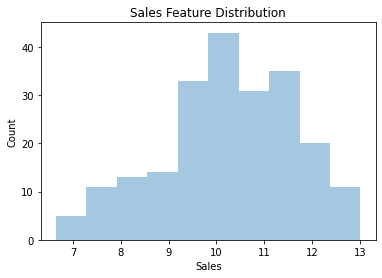

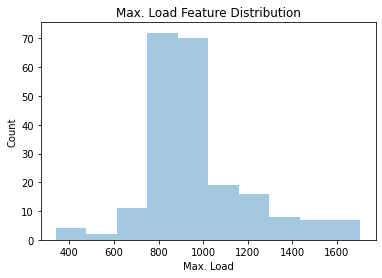

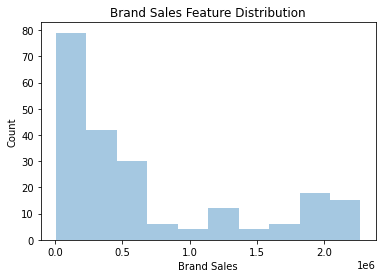

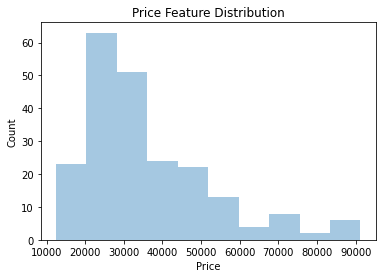

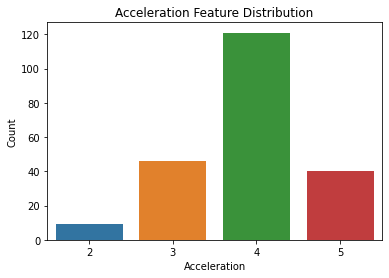

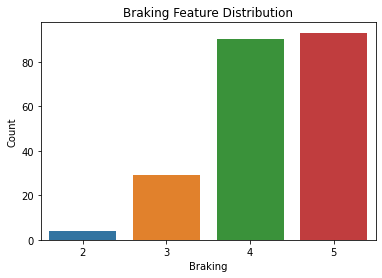

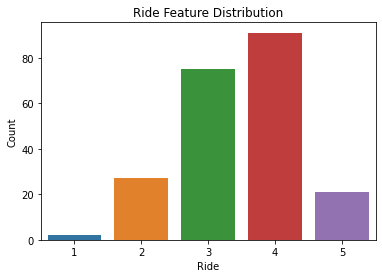

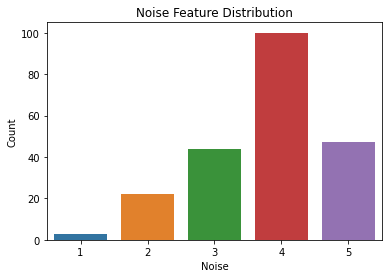

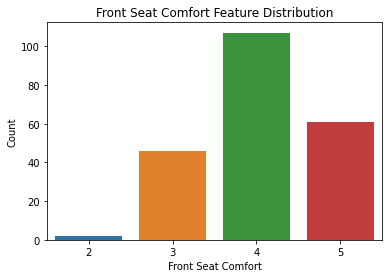

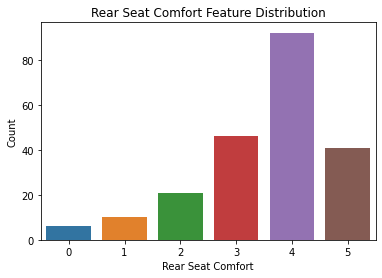

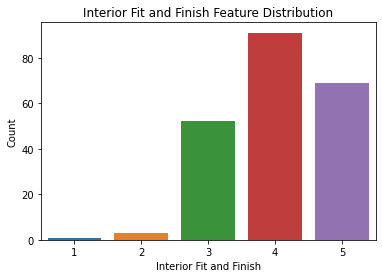

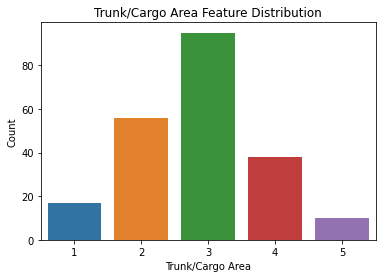

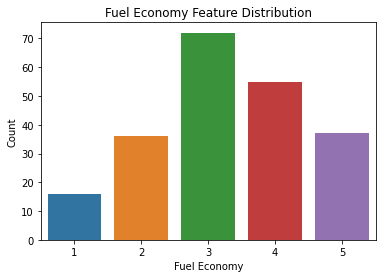

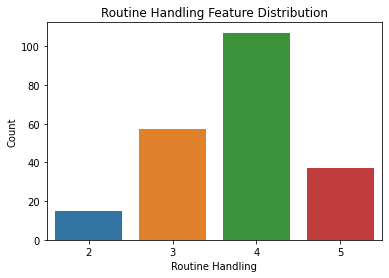

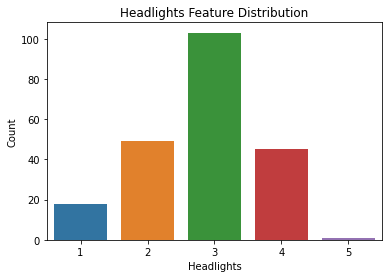

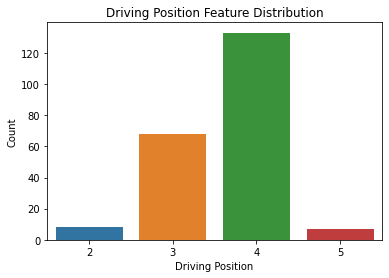

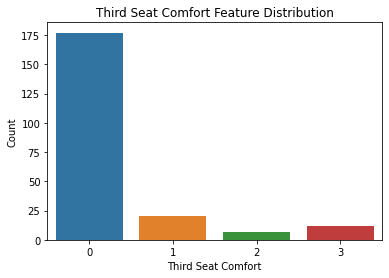

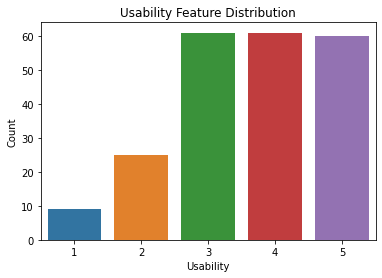

In [186]:
dist_columns = ['Sales', 'Max. Load', 'Brand Sales', 'Price']
other_columns = list(df.columns)
for dist_col in dist_columns:
    other_columns.remove(dist_col)
    
for col in dist_columns:
    fig, ax=plt.subplots()
    sns.distplot(df[col], bins=10, ax=ax, kde=False)
    ax.set_title(f'{col} Feature Distribution')
    ax.set_ylabel('Count')

for col in other_columns:
    fig, ax=plt.subplots()
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(f'{col} Feature Distribution')
    ax.set_ylabel('Count')

Plot relationship of each feature to the dependent variable

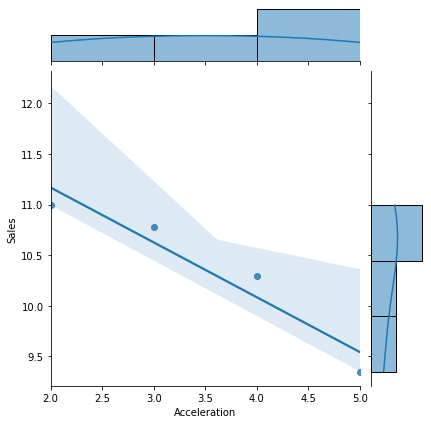

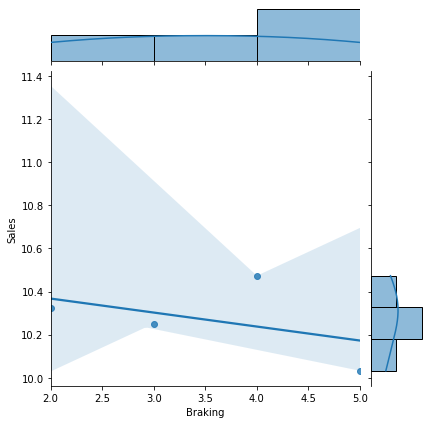

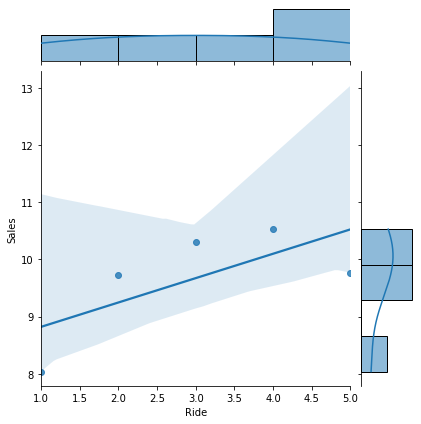

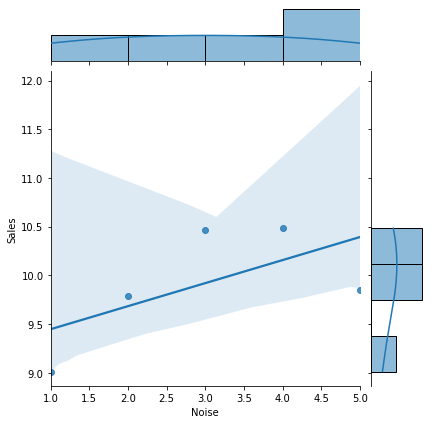

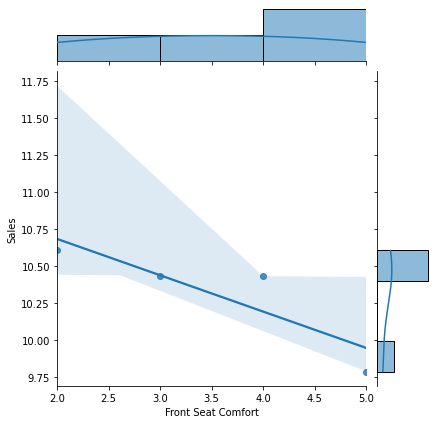

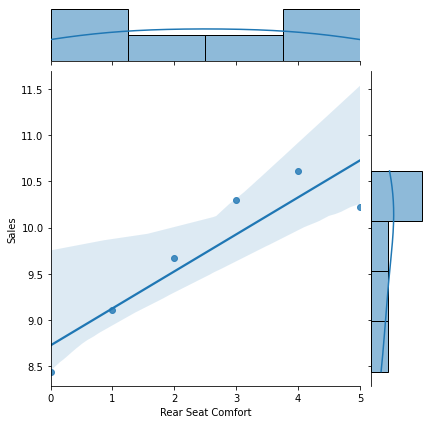

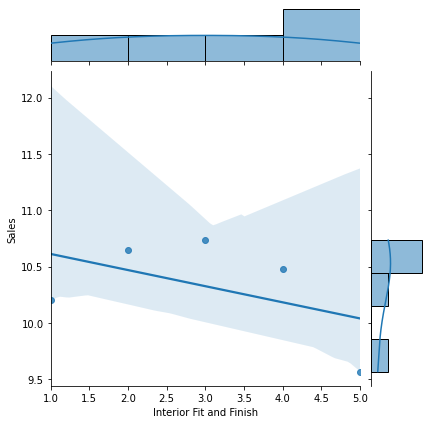

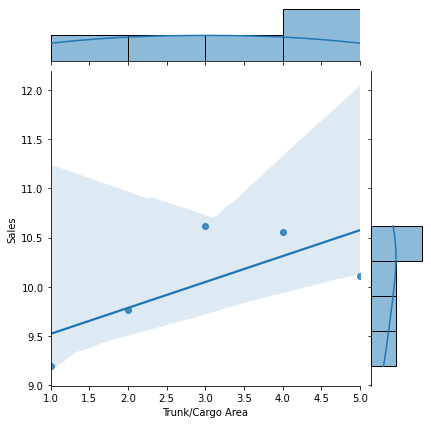

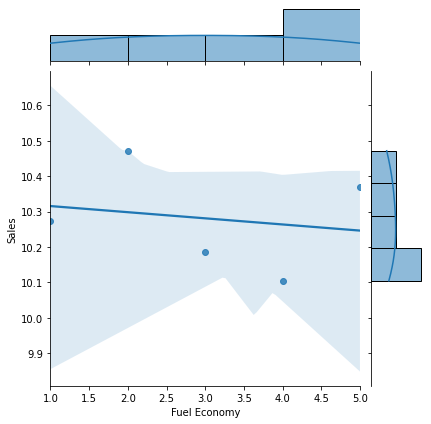

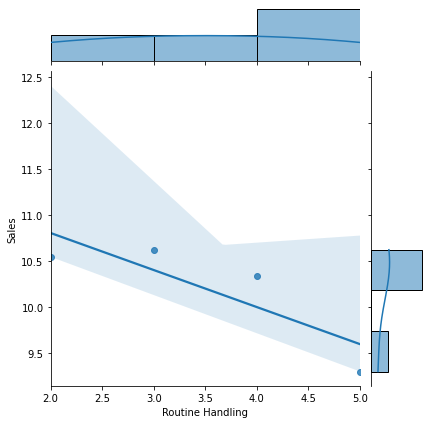

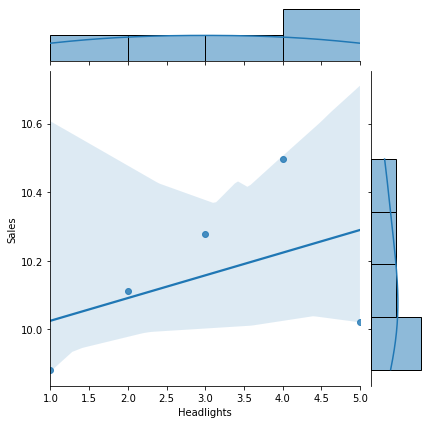

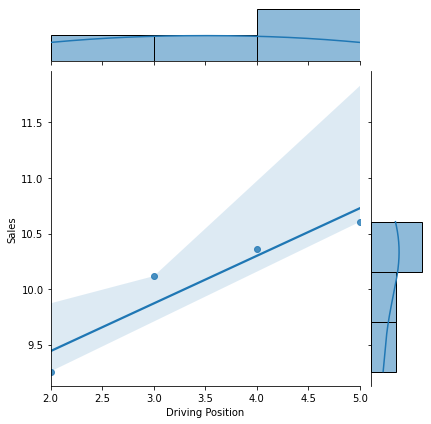

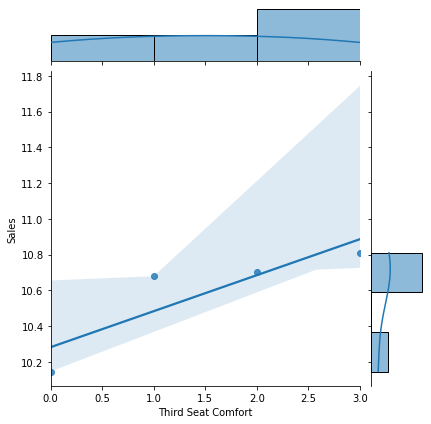

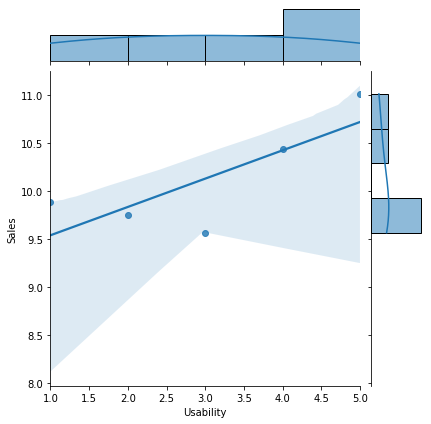

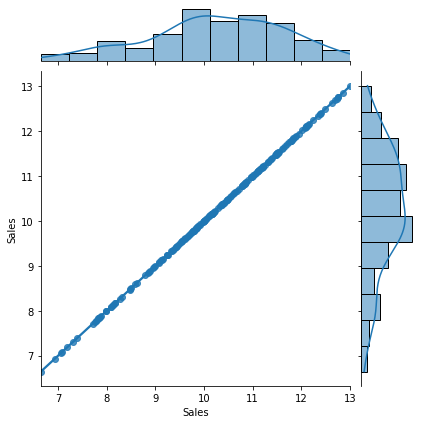

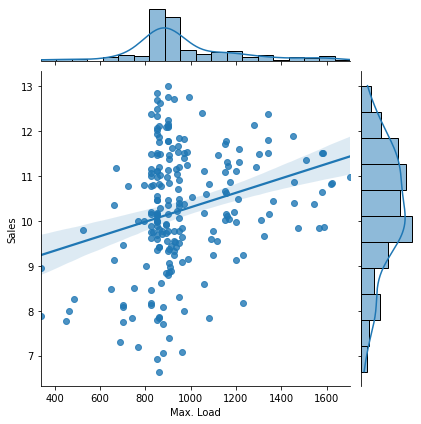

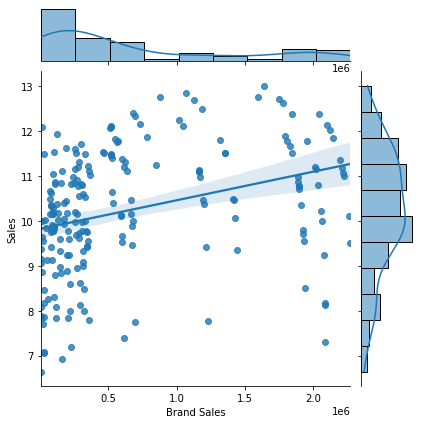

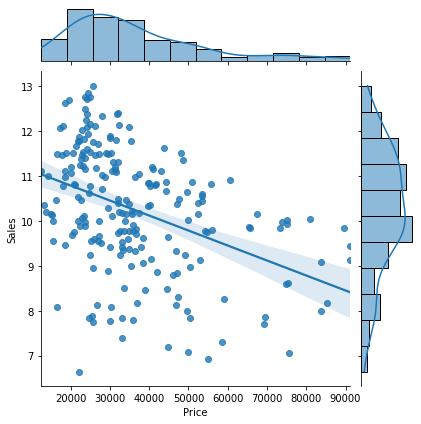

In [187]:
for col in other_columns:
    joint_df = df.groupby(col).mean().reset_index()
    plot = sns.jointplot(x=col, y='Sales', data=joint_df, kind='reg')
    plot.ax_joint.set_ylabel('Sales')

    
for col in dist_columns:
    sns.jointplot(x=col, y='Sales', data=df, kind='reg', ax=ax)

Use vif to find heavily correlated features

In [188]:
vif_x = df.drop(columns=['Sales'])
vif_y = df['Sales']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, random_state=71, test_size=.5)

vif_df = add_constant(vif_x_train)
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.reset_index(drop=True, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,258.1
1,Noise,5.1
2,Interior Fit and Finish,4.2
3,Front Seat Comfort,3.0
4,Ride,2.9
5,Price,2.5
6,Rear Seat Comfort,2.4
7,Max. Load,2.3
8,Trunk/Cargo Area,2.1
9,Acceleration,2.1


Calculate correlation for all features

<AxesSubplot:>

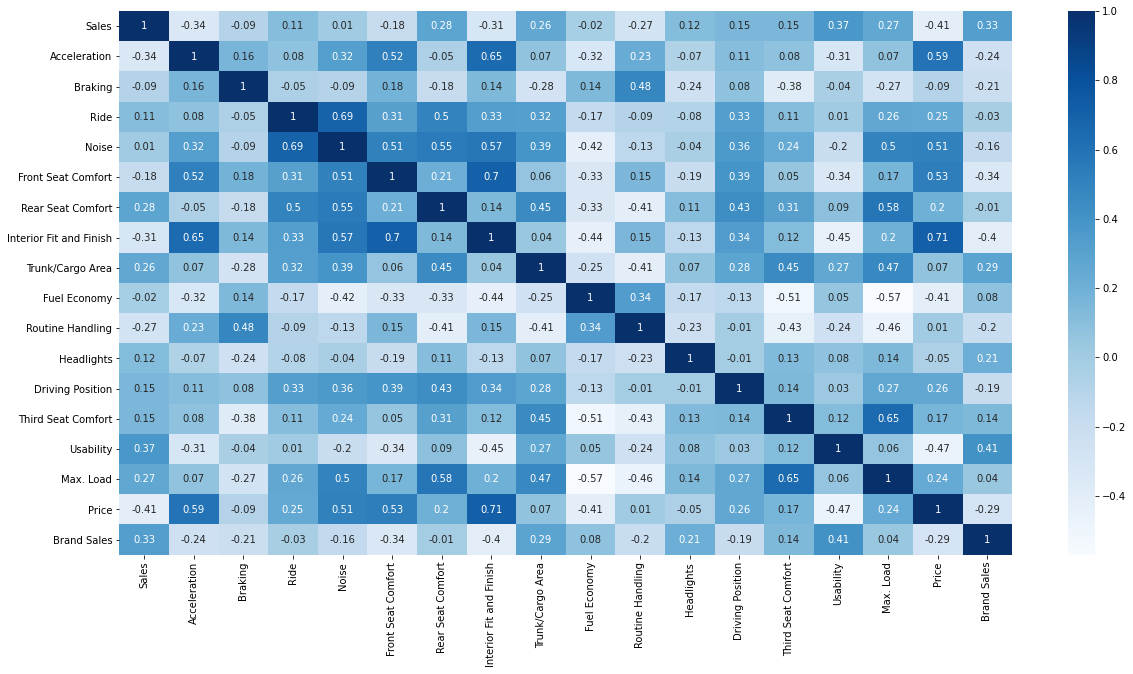

In [189]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df.corr().round(2), annot=True, cmap='Blues', ax=ax)

# Model Data

Create x and y variables

In [190]:
x = df.drop(columns=['Sales'])
y = df['Sales']

Perform train test split

In [191]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=71, test_size=.5)

Standard scale x variables

In [192]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns, index=x_test.index)

Build dummy regressor model

In [193]:
dr = DummyRegressor()
dr.fit(x_train, y_train)
y_train_pred_dr = dr.predict(x_train)
y_test_pred_dr = dr.predict(x_test)
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_train_pred_dr)))
print('Train MAE: ', mean_absolute_error(y_train, y_train_pred_dr))
print('Train R2: ', r2_score(y_train, y_train_pred_dr))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_test_pred_dr)))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred_dr))
print('Test R2: ', r2_score(y_test, y_test_pred_dr))

Train RMSE:  1.3155220046459088
Train MAE:  1.0570795823990464
Train R2:  0.0
Test RMSE:  1.412707021231357
Test MAE:  1.142964647229948
Test R2:  -0.005276511610557533


Build and evaluate linear regression model

In [194]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print('Train MAE: ', mean_absolute_error(y_train, y_train_pred_lr))
print('Train R2: ', r2_score(y_train, y_train_pred_lr))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred_lr))
print('Test R2: ', r2_score(y_test, y_test_pred_lr))

Train RMSE:  0.9857504964865339
Train MAE:  0.7988249429454788
Train R2:  0.43851549575789495
Test RMSE:  1.1908998908711803
Test MAE:  0.9448514763302165
Test R2:  0.28561580283475074


Gridsearch Lasso model

In [197]:
la_gs_dic = {'alpha': [x/1000 for x in range(0, 201)]}
la_gs_model = Lasso()
la_gs = GridSearchCV(la_gs_model, la_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
la_gs.fit(x_train, y_train)
print('Lasso Gridsearch')
print('Best Params', la_gs.best_params_)
print('Best Score', la_gs.best_score_)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits
Lasso Gridsearch
Best Params {'alpha': 0.088}
Best Score -1.3059527725329914


Build and evaluate Lasso model

In [198]:
la = Lasso(alpha=.088)
la.fit(x_train, y_train)
y_train_pred_la = la.predict(x_train)
y_test_pred_la = la.predict(x_test)
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_train_pred_la)))
print('Train MAE: ', mean_absolute_error(y_train, y_train_pred_la))
print('Train R2: ', r2_score(y_train, y_train_pred_la))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_test_pred_la)))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred_la))
print('Test R2: ', r2_score(y_test, y_test_pred_la))

Train RMSE:  1.0187977448766372
Train MAE:  0.8038779642900371
Train R2:  0.4002369364950995
Test RMSE:  1.1598464531771113
Test MAE:  0.9139038879652815
Test R2:  0.3223860697220289


Gridsearch Adaboost model

In [201]:
ab_gs_dic = {'learning_rate': [x/100 for x in range(1, 201)]}
ab_gs_model = AdaBoostRegressor(random_state=57)
ab_gs = GridSearchCV(ab_gs_model, ab_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
ab_gs.fit(x_train, y_train)
print('Adaboost Gridsearch')
print('Best Params', ab_gs.best_params_)
print('Best Score', ab_gs.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Adaboost Gridsearch
Best Params {'learning_rate': 0.7}
Best Score -1.0518648897699936


Build and evaluate top performing Adaboost model

In [202]:
ab = AdaBoostRegressor(learning_rate=.7, random_state=57)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_ab)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_ab))
print('Train R Squared', r2_score(y_train, y_train_pred_ab))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_ab)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_ab))
print('Test R Squared', r2_score(y_test, y_test_pred_ab))

Adaboost
Train RMSE 0.5838141424572328
Train MAE 0.5150064189474816
Train R Squared 0.8030513588753073
Test RMSE 1.1494411954700232
Test MAE 0.9444653353549768
Test R Squared 0.3344896039210591


In [203]:
pd.DataFrame(la.coef_, index=x.columns).sort_values(by=0)

,0
Price,-0.528298
Acceleration,-0.009817
Third Seat Comfort,0.000000
Routine Handling,0.000000
Interior Fit and Finish,-0.000000
Fuel Economy,-0.000000
Front Seat Comfort,-0.000000
Noise,0.000000
Ride,0.000000
Braking,-0.000000
